In [1]:
# %pylab inline
%matplotlib inline
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import numpy as np
import random
np.set_printoptions(suppress=True)
%autosave 10

Autosaving every 10 seconds


In [2]:
TOP_SCORE = 21
ACE_VALUE = 1
blackjackDecks = 2
blackjackCardsRem = 52 * blackjackDecks
blackjackCardTypeRem = np.zeros(10)
blackjackChance = np.zeros(10)
# Should create a 3D array from 1 to 21 with a regret for hit and stand for each number.
regretSumBlackjack = np.zeros((21, 2))
for i in range(10):
    if i == 9:
        blackjackCardTypeRem[i] = 16 * blackjackDecks
        blackjackChance[i] = blackjackCardTypeRem[i] / (52 * blackjackDecks)
    else:
        blackjackCardTypeRem[i] = 4 * blackjackDecks
        blackjackChance[i] = blackjackCardTypeRem[i] / (52 * blackjackDecks)

trainBlackjackCardsRem = blackjackCardsRem
trainBlackjackCardTypeRem = np.copy(blackjackCardTypeRem)
trainBlackjackChance = np.copy(blackjackChance)
# print(blackjackChance)

In [3]:
def changeCardChance(dealtCard):
    global trainBlackjackCardsRem
    global trainBlackjackCardTypeRem
    global trainBlackjackChance
#     if dealtCard >= 10:
#         print(dealtCard)
#     else:
#         dealtCard -= 1
#         print(dealtCard)

#     print('after: ', dealtCard)
    trainBlackjackCardsRem -= 1
#     print(trainBlackjackCardTypeRem)
    trainBlackjackCardTypeRem[dealtCard - 1] -= 1
#     trainBlackjackChance[dealtCard - 1] = trainBlackjackCardTypeRem[dealtCard - 1] / trainBlackjackCardsRem
    trainBlackjackChance = trainBlackjackCardTypeRem / trainBlackjackCardsRem
    return 0

def blackjackHit():
#     print(trainBlackjackChance)
    cumSumTrainBlackjackChance = np.cumsum(trainBlackjackChance)
    randomInt = random.random()
#     print(cumSumTrainBlackjackChance)
#     print(randomInt)
    dealtCard = (np.searchsorted(cumSumTrainBlackjackChance, randomInt) + 1)
#     print('before: ', dealtCard)
    changeCardChance(dealtCard)
    return dealtCard

def trainBlackjackHit(handValue, regretSum):
    tempHandValue = handValue
    dealtCard = blackjackHit()
    handValue += dealtCard
    if(handValue <= 21):
        regretSum[tempHandValue][1] += 1
        regretSum[tempHandValue][0] -= 1
    else:
        regretSum[tempHandValue][1] -= 1
        regretSum[tempHandValue][0] += 1
    return handValue, regretSum

In [4]:
def normalizeBlackjack(strategy):
    # If strategy is zeroes, then each index given equal fraction.
    strategy = np.copy(strategy)
    for i in range(21):
        normalizingSum = np.sum(strategy[i])
        if normalizingSum > 0:
            strategy[i] /= normalizingSum
        else:
            strategy[i] = np.ones(strategy.shape[1])/strategy.shape[1]
    return strategy

def getStrategyBlackjack(regretSum):
#     print('shape3: ', regretSum.shape)
    return normalizeBlackjack(np.maximum(regretSum, 0))

def getActionBlackjack(strategy, value):
    strategy[value] = strategy[value] / np.sum(strategy[value]) # Normalize
#     print(np.cumsum(strategy[value]))
    # Index zero (0) is stand and indes one (1) is hit.
    return np.searchsorted(np.cumsum(strategy[value]), random.random())

In [5]:
def getHand(myStrategy):
    # Get the first two cards for the hand.
        # These two cards are required and any hit after this is not.
    handValue = blackjackHit() + blackjackHit()
    while handValue < 21:
        action = getActionBlackjack(myStrategy, handValue)
        if action == 1:
            handValue += blackjackHit()
        elif action == 0:
            break
    return handValue

def getResult(myHand):
    houseHand = blackjackHit() + blackjackHit()
    while myHand > houseHand:
        houseHand += blackjackHit()
        
#     print(myHand, ' ', houseHand)
    if houseHand == myHand:
        return 0
    elif houseHand > myHand and houseHand <= TOP_SCORE:
        return -1
    elif houseHand > TOP_SCORE:
        return 1

In [6]:
def innertrainStratJackblack(regretSum, strategySum):
#     print(handValue)
    
    # accum the current strategy based on regret
    strategy = getStrategyBlackjack(regretSum)
    strategySum += strategy
    
    # Must give first two cards to hand.
    handValue, regretSum = trainBlackjackHit(0, regretSum)
    handValue, regretSum = trainBlackjackHit(handValue, regretSum)
    if handValue == 21:
        return regretSum, strategySum
    
#     print(strategy.shape)
#     print(regretSum)
#     print(strategy)
#     print(strategySum)

    # select my action and opponent action
    while handValue < 21:
        tempHandValue = handValue
        handValue, regretSum = trainBlackjackHit(handValue, regretSum)
                    
    
#     print(strategySum)
#     print(trainBlackjackCardTypeRem)
#     print('RegretSum: ', '\n', regretSum, '\n')
#     print(regretSum.shape, '\n')
#     print('StrategySum: ', '\n', strategySum, '\n')
#     print(strategySum.shape, '\n')
#     print('AceRegretSum: ', '\n', aceRegretSum, '\n')
#     print(aceRegretSum.shape, '\n')
#     print('AceStrategySum: ', '\n', aceStrategySum, '\n')
#     print(aceStrategySum.shape, '\n')
    
    return regretSum, strategySum
    
def trainStratBlackjack(oiterations, iterations):
    strategySum = np.copy(regretSumBlackjack)
#     print('shape: ', strategySum.shape)
    
    for j in range(oiterations):
        regretSum = np.zeros(regretSumBlackjack.shape)
        global trainBlackjackCardsRem
        global trainBlackjackCardTypeRem
        global trainBlackjackChance
#         print('shape2: ', regretSum.shape)
#         print('beforeTrainRegretSum: ', regretSum)
        
        for i in range(iterations):
            regretSum, strategySum = innertrainStratJackblack(regretSum, strategySum)
            if trainBlackjackCardsRem < (blackjackCardsRem / 2):
                trainBlackjackCardsRem = blackjackCardsRem
                trainBlackjackCardTypeRem = np.copy(blackjackCardTypeRem)
                trainBlackjackChance = np.copy(blackjackChance)
        
#         print('RegretSum: ' , regretSumP1)
#         print("%d" % j, normalizeBlackjack(strategySum))
        
    return strategySum

s1 = trainStratBlackjack(30, 2500)
normalizeBlackjack(s1)

array([[0.0002    , 0.9998    ],
       [0.00171333, 0.99828667],
       [0.00255333, 0.99744667],
       [0.00200667, 0.99799333],
       [0.00166   , 0.99834   ],
       [0.00183333, 0.99816667],
       [0.00169333, 0.99830667],
       [0.00238667, 0.99761333],
       [0.00122   , 0.99878   ],
       [0.00124667, 0.99875333],
       [0.00058   , 0.99942   ],
       [0.00160667, 0.99839333],
       [0.01901333, 0.98098667],
       [0.01602667, 0.98397333],
       [0.19022667, 0.80977333],
       [0.81792667, 0.18207333],
       [0.96446667, 0.03553333],
       [0.99239333, 0.00760667],
       [0.99400667, 0.00599333],
       [0.99678   , 0.00322   ],
       [0.99857333, 0.00142667]])

In [7]:
myStrategy = normalizeBlackjack(s1)
myStrategy

array([[0.0002    , 0.9998    ],
       [0.00171333, 0.99828667],
       [0.00255333, 0.99744667],
       [0.00200667, 0.99799333],
       [0.00166   , 0.99834   ],
       [0.00183333, 0.99816667],
       [0.00169333, 0.99830667],
       [0.00238667, 0.99761333],
       [0.00122   , 0.99878   ],
       [0.00124667, 0.99875333],
       [0.00058   , 0.99942   ],
       [0.00160667, 0.99839333],
       [0.01901333, 0.98098667],
       [0.01602667, 0.98397333],
       [0.19022667, 0.80977333],
       [0.81792667, 0.18207333],
       [0.96446667, 0.03553333],
       [0.99239333, 0.00760667],
       [0.99400667, 0.00599333],
       [0.99678   , 0.00322   ],
       [0.99857333, 0.00142667]])

In [8]:
# array = np.copy(regretSumBlackjack)
# print(array)
# array2 = array.shape[1]
# print(array2) 
# array3 = np.zeros(3)
# print(np.ones(array3.shape[0]) / 2)
# strategySum = np.copy(regretSumBlackjack)
# print(strategySum.shape)
# array4 = np.ones(array.shape) / 2
# print(array4)
# array5 = np.ones(3)
# array5 += 1
# array6 = array5 - 1
# print(array6)
# print(regretSumBlackjack.shape[1])
# array7 = np.arange(50)
# array7 = array7.reshape(10, 5)
# print(array7)
# array8 = array7[5][0:3]
# array8

([<matplotlib.lines.Line2D at 0x1161cd0b8>], -15.22, -15.5)

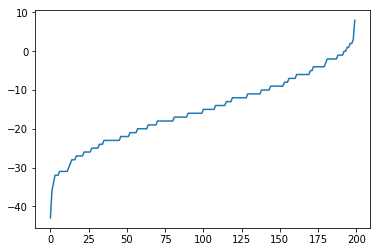

In [9]:
trainBlackjackCardsRem = blackjackCardsRem
trainBlackjackCardTypeRem = np.copy(blackjackCardTypeRem)
trainBlackjackChance = np.copy(blackjackChance)
vvv = []
for j in range(200):
    vv = 0
    for i in range(100):
#         strategy = getStrategy()
#         strategy = [0,1,0]
        myHand = getHand(myStrategy)
#         print(myHand)
        if myHand > 21:
            vv -= 1
        else:
            result = getResult(myHand)
#             print(result)
            vv += result
#             print(vv)
        if trainBlackjackCardsRem < 62:
                trainBlackjackCardsRem = blackjackCardsRem
                trainBlackjackCardTypeRem = np.copy(blackjackCardTypeRem)
                trainBlackjackChance = np.copy(blackjackChance)
#     print(vv)
    vvv.append(vv)
plt.plot(sorted(vvv)), np.mean(vvv), np.median(vvv)